### Load Packages

In [1]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import os
import tensorflow as tf

### Unzip IITD_database

In [6]:
# Run it only once
with zipfile.ZipFile("IITD_database.zip","r") as zip_ref:
    zip_ref.extractall("")

### Sample Images

In [4]:
image_path = "IITD_database/people/001/01_L.bmp"
image = Image.open(image_path)
np.asarray(image).shape

(240, 320, 3)

Image size:  (240, 320, 3)


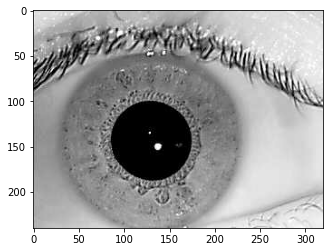

In [72]:
image_path = "IITD_database/people/001/01_L.bmp"
image = Image.open(image_path)
plt.imshow(image, cmap='gray')
print("Image size: ", np.asarray(image).shape)

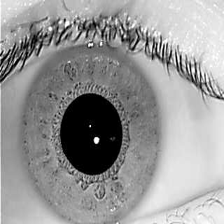

In [73]:
# resize image to (224,224)
image = image.resize((224,224))
image

(224, 224, 3)


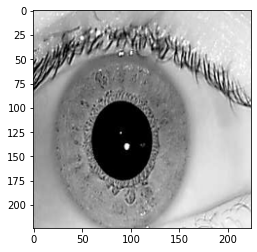

In [74]:
# convert to numpy array
image = np.asarray(image)
plt.imshow(image)
print(image.shape)

### Training Set Augmentation Method

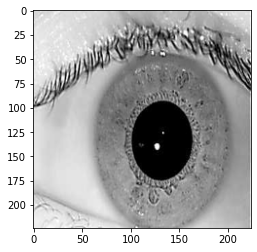

In [75]:
# Horizontal flip
image = np.flip(image,1)
plt.imshow(image)

### Prepare Data for Training and Testing

In [2]:
x_train, y_train = np.zeros([2688, 224, 224,3]), np.zeros([2688])
x_test, y_test = np.zeros([896, 224, 224,3]), np.zeros([896])

folder = "IITD_database/people"
i = 0
for people in range(1,225):
    person_folder = folder + "/" + "0"*(3-len(str(people))) + str(people)
    file_names = os.listdir(person_folder)
    for num_image in range(1,7):
        path = person_folder + "/" + file_names[num_image-1]
        image = Image.open(path)
        image = image.resize((224,224))
        image = np.asarray(image)
        #x = image.reshape((1,224,224,3))
        row_num = i*6 + num_image -1
        x_train[row_num,:,:,:] = image
        y_train[row_num] = people
        
        flip = np.flip(x_train[i],1)
        flip = np.resize(flip, (1,224,224,3))
        x_train[row_num+1344,:,:,:] = flip
        y_train[row_num+1344] = people
    i += 1
    
i = 0
for people in range(1,225):
    person_folder = folder + "/" + "0"*(3-len(str(people))) + str(people)
    file_names = os.listdir(person_folder)
    for num_image in range(7,11):
        path = person_folder + "/" + file_names[num_image-1]
        image = Image.open(path)
        image = image.resize((224,224))
        image = np.asarray(image)
        #x = image.reshape((1,224,224,3))
        row_num = i*4 + num_image -7
        x_test[row_num,:,:,:] = image
        y_test[row_num] = people
    i += 1
    
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2688, 224, 224, 3), (2688,), (896, 224, 224, 3), (896,))

In [3]:
index_train = np.random.permutation(2688)
index_test = np.random.permutation(896)
x_train, y_train = x_train[index_train], y_train[index_train]
x_test, y_test = x_test[index_test], y_test[index_test]

In [4]:
x_train, x_test = tf.cast(x_train, tf.float32)/255.0, tf.cast(x_test, tf.float32)/255.0
y_train, y_test = tf.one_hot(y_train-1, depth=224), tf.one_hot(y_test-1, depth=224)
#y_train, y_test = tf.cast(y_train, tf.float32), tf.cast(y_test, tf.float32)

### Model Definition

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import Model

In [7]:
from tensorflow.keras import Model
pre_trained_model = ResNet50(input_shape=(224,224,3), weights='imagenet')
ResNet = Model(inputs=pre_trained_model.input,outputs=pre_trained_model.layers[-2].output)
#ResNet.summary()

# First time, train without adjusting the ResNet weights to train the final dense layer first
ResNet.trainable =  False
model = tf.keras.Sequential([
                             ResNet,
                             tf.keras.layers.Dense(224, activation='softmax')
                                      ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 224)               458976    
Total params: 24,046,688
Trainable params: 458,976
Non-trainable params: 23,587,712
_________________________________________________________________


In [8]:
model.add_loss(lambda: 0.01*tf.reduce_sum(tf.square(model.layers[-1].kernel)))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=tf.keras.metrics.CategoricalAccuracy())

In [9]:
model.fit(x_train, y_train, batch_size=24, epochs=1, validation_split=0.2)

90/90 [==============================] - 37s 253ms/step - loss: 8.9797 - categorical_accuracy: 0.0056 - val_loss: 7.1061 - val_categorical_accuracy: 0.0019


In [10]:
ResNet.trainable =  True
model.add_loss(lambda: 0.01*tf.reduce_sum(tf.square(model.layers[-1].kernel)))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0002),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=tf.keras.metrics.CategoricalAccuracy())

model.fit(x_train, y_train, batch_size=24, epochs=15, validation_split=0.2)

Epoch 1/15
90/90 [==============================] - 61s 606ms/step - loss: 7.7928 - categorical_accuracy: 0.1958 - val_loss: 8.1769 - val_categorical_accuracy: 0.0056
Epoch 2/15
90/90 [==============================] - 52s 581ms/step - loss: 3.7742 - categorical_accuracy: 0.8684 - val_loss: 7.9336 - val_categorical_accuracy: 0.0093
Epoch 3/15
90/90 [==============================] - 52s 581ms/step - loss: 2.2048 - categorical_accuracy: 0.9808 - val_loss: 7.6023 - val_categorical_accuracy: 0.0074
Epoch 4/15
90/90 [==============================] - 52s 580ms/step - loss: 1.5602 - categorical_accuracy: 0.9990 - val_loss: 6.7625 - val_categorical_accuracy: 0.0074
Epoch 5/15
90/90 [==============================] - 52s 580ms/step - loss: 1.1519 - categorical_accuracy: 0.9981 - val_loss: 6.3494 - val_categorical_accuracy: 0.0093
Epoch 6/15
90/90 [==============================] - 52s 579ms/step - loss: 0.8600 - categorical_accuracy: 1.0000 - val_loss: 6.0349 - val_categorical_accuracy: 0.013

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2)
model.fit(x_train, y_train, batch_size=24, epochs=20, validation_split=0.2, callbacks=[early_stop])

Epoch 1/20
90/90 [==============================] - 52s 583ms/step - loss: 0.2079 - categorical_accuracy: 1.0000 - val_loss: 0.5334 - val_categorical_accuracy: 0.9517
Epoch 2/20
90/90 [==============================] - 52s 580ms/step - loss: 0.1870 - categorical_accuracy: 1.0000 - val_loss: 0.4060 - val_categorical_accuracy: 0.9684
Epoch 3/20
90/90 [==============================] - 52s 580ms/step - loss: 0.1733 - categorical_accuracy: 1.0000 - val_loss: 0.3526 - val_categorical_accuracy: 0.9721
Epoch 4/20
90/90 [==============================] - 52s 580ms/step - loss: 0.1649 - categorical_accuracy: 1.0000 - val_loss: 0.3408 - val_categorical_accuracy: 0.9628
Epoch 5/20
90/90 [==============================] - 52s 580ms/step - loss: 0.1511 - categorical_accuracy: 1.0000 - val_loss: 0.2848 - val_categorical_accuracy: 0.9684
Epoch 6/20
90/90 [==============================] - 52s 580ms/step - loss: 0.1529 - categorical_accuracy: 0.9991 - val_loss: 0.4004 - val_categorical_accuracy: 0.942

In [12]:
model.evaluate(x_test, y_test)

28/28 [==============================] - 8s 210ms/step - loss: 0.2582 - categorical_accuracy: 0.9799


[0.2581785321235657, 0.9799107313156128]

In [13]:
pred = model.predict(x_test)
np.mean(np.argmax(y_test, axis=1)==np.argmax(pred, axis=1))

0.9799107142857143

In [14]:
model.save_weights('./checkpoints/Delhi')
#model.load_weights('./checkpoints/my_checkpoint')

In [11]:
# %load_ext tensorboard
# !rm -rf ./logs/
# tb = tf.keras.callbacks.TensorBoard(log_dir='./logs/model', histogram_freq=1)

In [ ]:
# import datetime, os
# from packaging import version
# %load_ext tensorboard
# %tensorboard --logdir ./logs --bind_all#--host localhost